<a href="https://colab.research.google.com/github/JohnNuwan/Python_Trading_Repo/blob/master/Gold_Teste_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression

# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')


In [16]:
import pandas_datareader.data as web
import datetime    

start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2020, 12, 25)


In [17]:
# Price For Gold
df = web.DataReader("GC=F", 'yahoo', start, end)

dates =[]
for x in range(len(df)):
    newdate = str(df.index[x])
    newdate = newdate[0:10]
    dates.append(newdate)

df['dates'] = dates

print(df.head())
print(df.tail())

                  High         Low        Open  ...  Volume   Adj Close       dates
Date                                            ...                                
2008-01-02  857.799988  846.400024  848.700012  ...   130.0  857.000000  2008-01-02
2008-01-03  865.500000  856.299988  863.000000  ...   181.0  866.400024  2008-01-03
2008-01-04  865.500000  860.200012  861.400024  ...    28.0  863.099976  2008-01-04
2008-01-07  860.900024  857.400024  860.900024  ...     4.0  859.599976  2008-01-07
2008-01-08  879.400024  861.599976  861.599976  ...    21.0  878.000000  2008-01-08

[5 rows x 7 columns]
                   High          Low  ...    Adj Close       dates
Date                                  ...                         
2020-12-18  1889.500000  1882.300049  ...  1885.699951  2020-12-18
2020-12-21  1908.000000  1869.099976  ...  1879.199951  2020-12-21
2020-12-22  1882.199951  1861.000000  ...  1866.599976  2020-12-22
2020-12-23  1878.800049  1864.500000  ...  1874.699951 

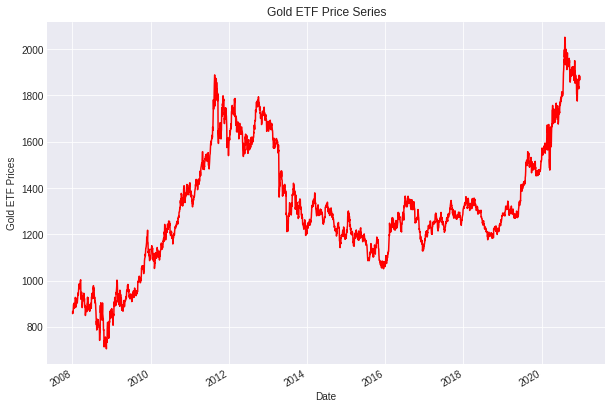

In [18]:
# Plot the closing price of GLD
df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()

In [19]:
# Define explanatory variables
df['S_3'] = df['Close'].rolling(window=3).mean()
df['S_9'] = df['Close'].rolling(window=9).mean()
df['next_day_price'] = df['Close'].shift(-1)

df = df.dropna()
X = df[['S_3', 'S_9']]

# Define dependent variable
y = df['next_day_price']

In [20]:
# Split the data into train and test dataset
t = .8
t = int(t*len(df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

In [21]:
# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold ETF Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
Gold ETF Price (y) = 1.20 * 3 Days Moving Average (x1) + -0.20 * 9 Days Moving Average (x2) + 4.58 (constant)


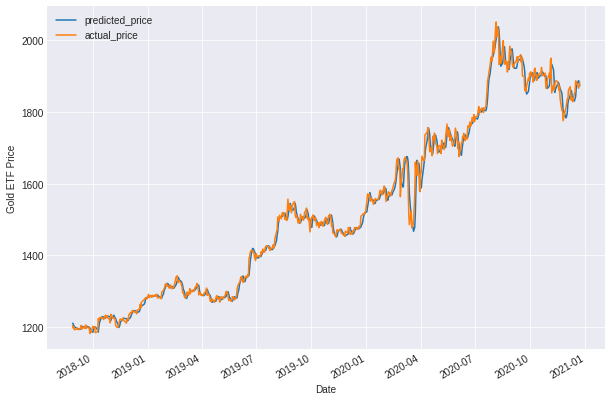

In [22]:
# Predicting the Gold ETF prices
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold ETF Price")
plt.show()

In [23]:
# R square
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

99.27

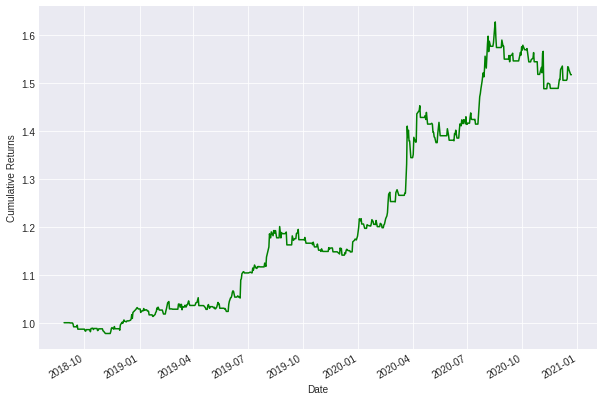

In [24]:
gold = pd.DataFrame()

gold['price'] = df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)

gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day,1,0)

gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g')
plt.ylabel('Cumulative Returns')
plt.show()

In [25]:
'Sharpe Ratio %.2f' % (gold['strategy_returns'].mean()/gold['strategy_returns'].std()*(252**0.5))

'Sharpe Ratio 1.43'

In [27]:
data = web.DataReader("GC=F", 'yahoo', start, end)
#data = yf.download('GLD', '2008-06-01', '2020-6-25', auto_adjust=True)
data['S_3'] = data['Close'].rolling(window=3).mean()
data['S_9'] = data['Close'].rolling(window=9).mean()
data = data.dropna()
data['predicted_gold_price'] = linear.predict(data[['S_3', 'S_9']])
data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price,"Buy","No Position")
data.tail(7)

,High,Low,Open,Close,Volume,Adj Close,S_3,S_9,predicted_gold_price,signal
Date,,,,,,,,,,
2020-12-16,1864.699951,1850.500000,1856.500000,1856.099976,1090.0,1856.099976,1845.699992,1845.955566,1843.794726,Buy
2020-12-17,1896.199951,1874.199951,1874.199951,1887.199951,414.0,1887.199951,1865.199992,1851.655558,1866.004014,Buy
2020-12-18,1889.500000,1882.300049,1882.400024,1885.699951,276.0,1885.699951,1876.333293,1854.311103,1878.804663,Buy
2020-12-21,1908.000000,1869.099976,1884.800049,1879.199951,136.0,1879.199951,1884.033285,1855.244425,1887.839614,Buy
2020-12-22,1882.199951,1861.000000,1882.199951,1866.599976,233.0,1866.599976,1877.166626,1858.799981,1878.899400,No Position
2020-12-23,1878.800049,1864.500000,1867.000000,1874.699951,82.0,1874.699951,1873.499959,1863.366645,1873.588538,No Position
2020-12-24,1887.400024,1873.099976,1877.300049,1883.199951,87445.0,1883.199951,1874.833293,1868.188856,1874.215073,Buy


In [30]:
data['signal']

Date
2008-01-14    No Position
2008-01-15            Buy
2008-01-16    No Position
2008-01-17    No Position
2008-01-18    No Position
                 ...     
2020-12-18            Buy
2020-12-21            Buy
2020-12-22    No Position
2020-12-23    No Position
2020-12-24            Buy
Name: signal, Length: 3317, dtype: object

In [32]:
data['predicted_gold_price']

Date
2008-01-14     901.840972
2008-01-15     904.570136
2008-01-16     898.064149
2008-01-17     888.873890
2008-01-18     880.334867
                 ...     
2020-12-18    1878.804663
2020-12-21    1887.839614
2020-12-22    1878.899400
2020-12-23    1873.588538
2020-12-24    1874.215073
Name: predicted_gold_price, Length: 3317, dtype: float64